<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import numpy as np
import pandas as pd
import random


In [123]:
 # Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L_avg = 1.5  # Давление в линии нефтесбора

p_L = p_L_avg
p_L_rand = p_L_avg

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 3  # устьевого штуцера
r_GU = 3  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
q_0 = 90  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]
lambda_2 = [0.5, 0.82, 0.74]
lambda_3 = [0.42, 0.18, 0.3]


S_t = 0.01  # Площадь поперечного сечени НКТ
T_2 = 0.4  # Постоянна времени притока
t_N = 0.01  # Постоянная времени насоса

In [124]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
_q_L = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
___p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []
_betta_G3 = []
_betta_GN = []
_N_1 = []
_N_2 = []
_count = []
_n_NN = []
_agzu = []
_r_U = []
_p_L = []

In [125]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_1 = 0.083
r_2 = 0.017
r_R = 0.1

In [126]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [127]:
# Высота столба жидкости
gamma = (1-betta)*gamma_oil+betta*gamma_water
dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [128]:
h_0 = q_0*(r_U + r_N + r_K + r_R/gamma) - dH_R
h_0 = 2300

In [129]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
M_R3 = 0.16
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = 0.0000091 #k_S*X_G*M_R3

In [130]:
# Расчёт динамики

# Начальные условия

M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 90
q_L = 90
_q = 90
p_3 = p_L + gamma * h_4

agzu_on = False
agzu_timer = 0
r_U_summ = 0

# Если запсукаем не из нуля
p_1 = 12.63
p_2 = 20.116
p_3 = 4.207
p_4 = 1.532
h_4 = 332

epsilon = 0.00001 * p_3


# Сегмент напорной характеристики
i = 1
k = 35000
dt = 0.0001  # Суток

# Статика при вариации частоты
_N_1 = []
_N_2 = []
_count = []
_n_NN = []


In [131]:
dk = 24 * 60 * 60 * dt  # Секунд в одной итерации
dk

8.64

In [132]:
# Начало расчёта
for _k in range(k):
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
    p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
    __p_3 = p_4 + gamma * h_4
    # Балансировка притока по начальным условиям
    while abs(p_3 - __p_3) > epsilon:
        p_3 = (1-M_q)*p_3 + M_q*__p_3
        q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
        p_4 = (p_L + (p_G0 - p_3) * r_GU * np.sqrt(w) * a_GU * q)
        __p_3 = p_4 + gamma * h_4
    p_3 = __p_3
    p_8 =p_L + gamma*r_U*q_L

    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
    q_N = max(q_N, 0)

    if i > 0 and q_N > w*q_0*q_Pump[i]:
      i-=1
      i = max(i, 0)
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)

    if i < 2 and  q_N < w*q_0*q_Pump[i+1]:
      i+=1
      q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_8)) / (w*(h_0/q_0)*lambda_1[i]+r_N)
      q_N = max(q_N, 0)




    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))


    p_1 = p_2 - r_1*q
    p_5 = p_8 + gamma*(H_N+r_N*q_N)


    h_N = h_0*(w*w*lambda_0[i]-w*lambda_1[i]*(q_N/q_0))
    n_N = 0.5
    N_1_0 = (gamma*h_0*q_0)/n_N
    N_2 = gamma * h_N * q_N
    alpha_n_L =0.1
    alpha_n_R =0.07
    w_n_L = 0.96
    w_n_R = 1.04
    delta_n_N = alpha_n_L * max(w_n_L-w, 0) + alpha_n_R * max(w-w_n_R, 0)
    N_1 = N_1_0*(1+delta_n_N)*(w*w*w*lambda_2[i] + w*w*lambda_3[i]*(q_N/q_0))
    n_NN = N_2/N_1

    _p_1.append(p_1)
    _p_3.append(p_3)
    _p_4.append(p_4)
    _p_8.append(p_8)
    _q_N.append(q_N)
    __q.append(q)
    _q_L.append(q_L)
    _h_4.append(h_4)
    _u.append(w)
    _p_5.append(p_5)
    _N_1.append(N_1)
    _N_2.append(N_2)
    _n_NN.append(n_NN)
    _betta_G3.append(betta_G3)
    _betta_GN.append(betta_GN)
    _agzu.append(agzu_on)
    _r_U.append(r_U)
    _p_L.append(p_L)


    p_L_change = random.randint(700, 800)

    if _k > 0 and _k % p_L_change == 0 and agzu_on is False:
      p_L_rand = random.uniform(0.9 * p_L_avg, 1.1 * p_L_avg)

    # Каждые 12 часов включатся АГЗУ на 30 минут
    if _k > 0 and _k % 5000 == 0:
      agzu_on = True
      agzu_timer = 0
      p_L_rand = 0.7 * p_L_avg

    if agzu_on is True:
      agzu_timer += 1
      r_U_summ += (p_8 - p_L)

    if agzu_on is True and agzu_timer == 417:
      agzu_on = False
      agzu_timer = 0

      if not (_k * dt > 0.6 and _k * dt < 1.4) and not (_k * dt > 1.6 and _k * dt < 2.4) and not (_k * dt > 2.6 and _k * dt < 3.4):
          r_U = (r_U_summ/417) / (gamma*q_L)
      r_U_summ = 0
      p_L_rand = random.uniform(0.9 * p_L_avg, 1.1 * p_L_avg)

    # Шаг по Эйлеру
    p_2 = p_2 + (dt/T_2)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (dt/S_t)*(q-q_N)
    q_L = q_L + (dt/t_N)*(q_N-q_L)
    p_L = p_L + (dt/(dt*10))*(p_L_rand - p_L)


    if _k * dt == 1:
      w = 0.9
    if _k * dt == 2:
      w = 1.1
    if _k * dt == 3:
      w = 1

In [133]:
random.randint(500, 800)

754

In [134]:

x = np.linspace(0, k*dt, k)
x

array([0.00000000e+00, 1.00002857e-04, 2.00005714e-04, ...,
       3.49979999e+00, 3.49990000e+00, 3.50000000e+00])

In [135]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u, 'x': x,
                   'p_4': _p_4, 'p_8': _p_8, 'p_5': _p_5, 'N_1': _N_1, 'N_2': _N_2, 'n_NN': _n_NN,
                   'betta_G3': _betta_G3, 'betta_GN': _betta_GN, 'q_L': _q_L, 'agzu': _agzu, 'r_U': _r_U, 'p_L': _p_L})
df

,q_N,p_3,p_1,q,h_4,u,x,p_4,p_8,p_5,N_1,N_2,n_NN,betta_G3,betta_GN,q_L,agzu,r_U,p_L
0,90.203167,4.208198,12.631563,90.173945,332.000000,1.0,0.0000,1.532278,3.676200,22.704350,3338.195873,1668.411498,0.499794,0.433666,0.130100,90.000000,False,3.00000,1.500000
1,90.202950,4.208195,12.631597,90.173529,331.999708,1.0,0.0001,1.532278,3.676249,22.704392,3338.194424,1668.411516,0.499795,0.433667,0.130100,90.002032,False,3.00000,1.500000
2,90.202736,4.208193,12.631595,90.173562,331.999414,1.0,0.0002,1.532278,3.676298,22.704434,3338.192997,1668.411534,0.499795,0.433667,0.130100,90.004041,False,3.00000,1.500000
3,90.202525,4.208191,12.631593,90.173592,331.999122,1.0,0.0003,1.532278,3.676346,22.704475,3338.191586,1668.411552,0.499795,0.433667,0.130100,90.006028,False,3.00000,1.500000
4,90.202316,4.208188,12.631590,90.173621,331.998832,1.0,0.0004,1.532278,3.676393,22.704516,3338.190190,1668.411569,0.499795,0.433667,0.130100,90.007993,False,3.00000,1.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,89.691509,4.198898,12.619305,89.425775,313.917671,1.0,3.4996,1.668721,3.788786,22.800440,3334.781228,1668.400398,0.500303,0.434770,0.130431,89.701368,False,2.97665,1.636688
34996,89.691430,4.198877,12.619286,89.426272,313.915014,1.0,3.4997,1.668721,3.788783,22.800435,3334.780701,1668.400388,0.500303,0.434772,0.130432,89.701269,False,2.97665,1.636688
34997,89.691351,4.198855,12.619266,89.426768,313.912363,1.0,3.4998,1.668722,3.788781,22.800430,3334.780175,1668.400378,0.500303,0.434775,0.130432,89.701171,False,2.97665,1.636688
34998,89.691272,4.198834,12.619247,89.427264,313.909717,1.0,3.4999,1.668722,3.788779,22.800425,3334.779649,1668.400368,0.500303,0.434777,0.130433,89.701073,False,2.97665,1.636688


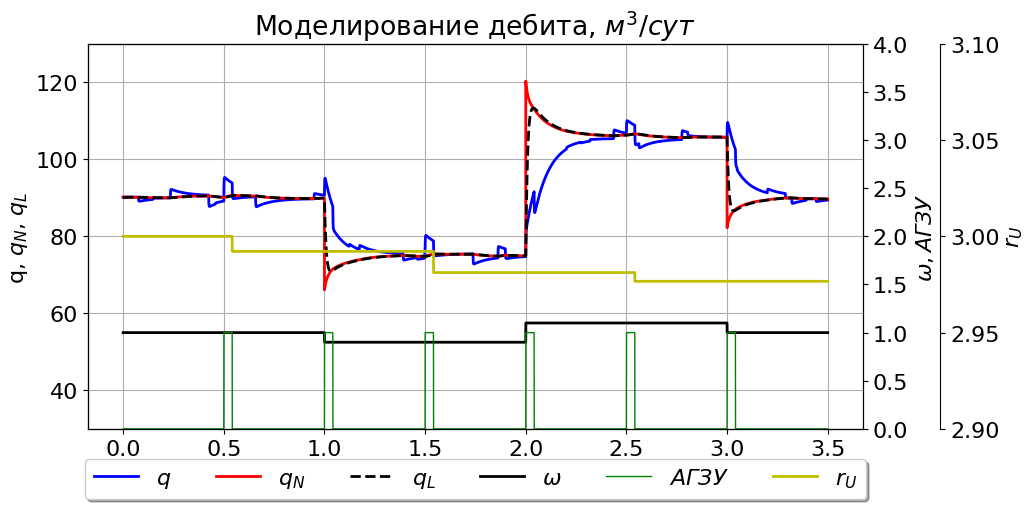

In [136]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.1))

plt.rcParams.update({'font.size': 16})

p1, = ax.plot(df['x'], df['q'], 'b', lw=2, label="$q$")
p2, = ax.plot(df['x'], df['q_N'], 'r', lw=2, label="$q_N$")
p3, = ax.plot(df['x'], df['q_L'], 'k--', lw=2, label="$q_L$")

p4, = twin1.plot(df['x'],  df['u'],'k', lw=2, label="$\omega$")
p5, = twin1.plot(df['x'],  df['agzu'],'g', lw=1, label="$АГЗУ$")
p6, = twin2.plot(df['x'],  df['r_U'],'y', lw=2, label="$r_U$")


ax.set(ylim=(30, 130), xlabel="Сутки", ylabel="q, $q_N$, $q_L$")
twin1.set(ylim=(0, 4), ylabel="$\omega, АГЗУ$")
twin2.set(ylim=(2.9, 3.1), ylabel="$r_U$")

plt.title('Моделирование дебита, $м^3/сут$')


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=6, handles=[p1, p2, p3, p4, p5, p6])
ax.grid()
plt.show()

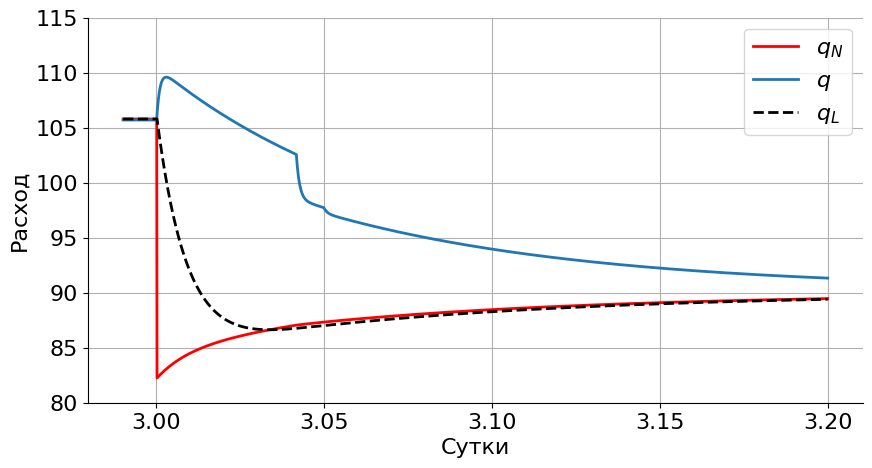

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

plt.plot(df['x'][29900:32000], df['q_N'][29900:32000], 'r', lw=2, label='$q_N$')
plt.plot(df['x'][29900:32000], df['q'][29900:32000], lw=2, label='$q$')
plt.plot(df['x'][29900:32000], df['q_L'][29900:32000], 'k--', lw=2, label='$q_L$')



# set x label
plt.xlabel('Сутки')
plt.ylabel('Расход')


plt.ylim(80, 115)
plt.grid(True)

plt.legend()

# display plot
plt.show()

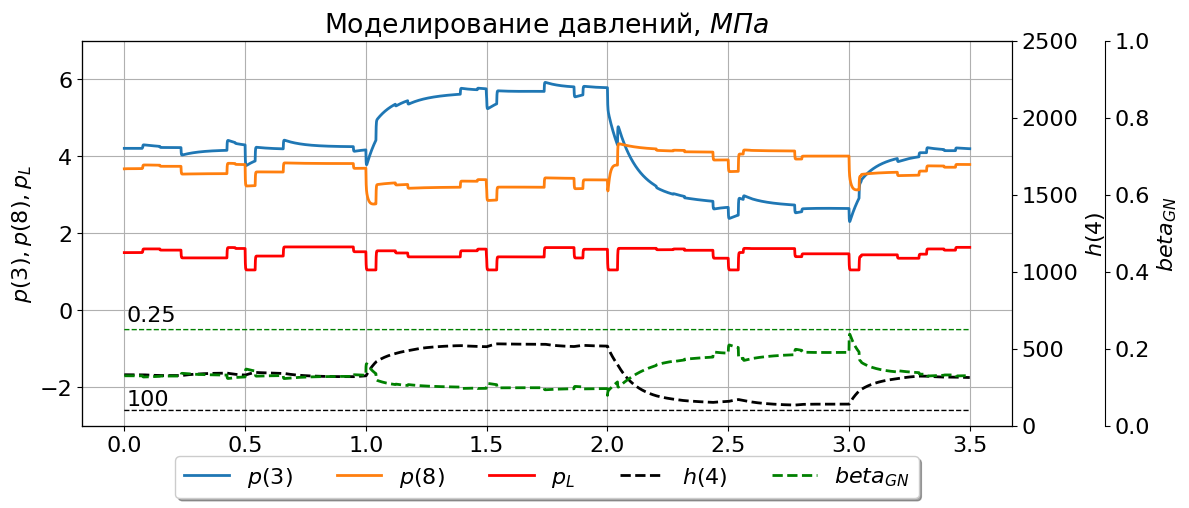

In [138]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12, 5))

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.1))
plt.rcParams.update({'font.size': 16})

p1, = ax.plot(df['x'], df['p_3'], lw=2, label="$p(3)$")
p2, = ax.plot(df['x'], df['p_8'], lw=2, label="$p(8)$")
p3, = ax.plot(df['x'], df['p_L'], 'r', lw=2, label="$p_L$")

p4, = twin1.plot(df['x'],  df['h_4'],'k--', lw=2, label="$h(4)$")

p5, = twin1.plot(df['x'],  [h_lim]*k,'k--', lw=1)
twin1.annotate(h_lim, xy = (df['x'][100], h_lim*1.3 ))

p5, = twin2.plot(df['x'],  df['betta_GN'],'g--', lw=2, label="$beta_{GN}$")
p6, = twin2.plot(df['x'],  [betta_G_lim]*k,'g--', lw=1)
twin2.annotate(betta_G_lim, xy = (df['x'][100], betta_G_lim*1.08 ))


ax.set(ylim=(-3, 7), xlabel="Сутки", ylabel="$p(3), p(8), p_L$")
twin1.set(ylim=(0, 2500), ylabel="$h(4)$")
twin2.set(ylim=(0, 1), ylabel="$beta_{GN}$")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3, p4, p5])

plt.title('Моделирование давлений, $МПа$')
ax.grid()
plt.show()

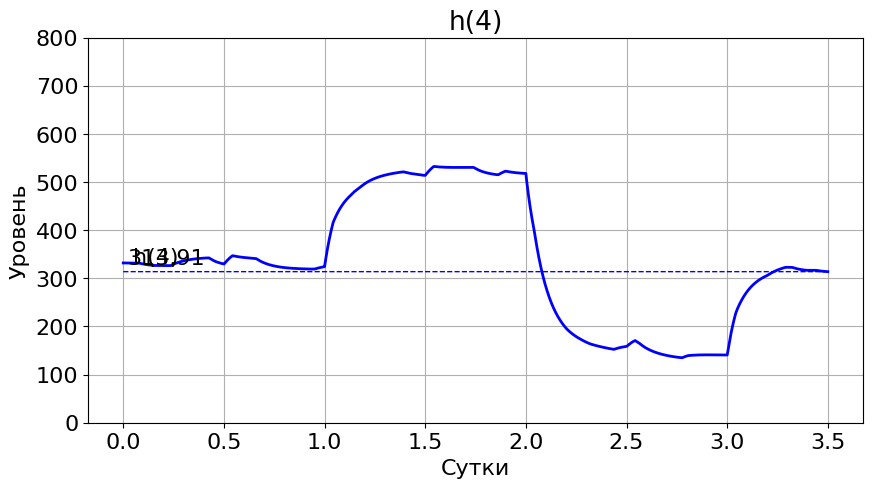

In [139]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(df['x'], df['h_4'],'b', lw=2)
plt.plot(df['x'], [df['h_4'][k-1]]*k,'b--', lw=1)

plt.annotate('h(4)', xy = (df['x'][500],df['h_4'][200] ))
plt.annotate(str(df['h_4'][k-1].round(2)), xy = (df['x'][200], df['h_4'][k-1]*1.05))

# set x label
plt.xlabel('Сутки')
plt.ylabel('Уровень')

# set title
plt.title('h(4)')
plt.ylim(0, 800)
plt.grid(True)
plt.show()

In [140]:
min_p = 0
max_p = 100
points = 1000

quant = np.linspace(min_p, max_p, points)
quant_step = (max_p - min_p) / points
quant_step

0.1

In [141]:
denominator = 1
ident_k = (k//denominator)
ident_dt = dt * denominator

def get_with_error(val, percent=1):
  return val + val *random.uniform(-percent/100, percent/100)

def generate_measurements(arr):
  return [get_with_error(val) for val in arr[::denominator]]


df_ident = pd.DataFrame({'p_3': [quant[round(index/quant_step)] for index in generate_measurements(_p_3)],
                         'p_4': [quant[round(index/quant_step)] for index in generate_measurements(_p_4)],
                         'p_8': [quant[round(index/quant_step)] for index in generate_measurements(_p_8)],
                         'p_L': [quant[round(index/quant_step)] for index in generate_measurements(_p_L)],
                         'r_U': [quant[round(index/quant_step)] for index in generate_measurements(_r_U)],
                         })

df_ident = pd.DataFrame({'p_3': generate_measurements(_p_3),
                         'p_4': generate_measurements(_p_4),
                         'p_8': generate_measurements(_p_8),
                         'p_L': generate_measurements(_p_L),
                         'r_U': generate_measurements(_r_U),
                        })

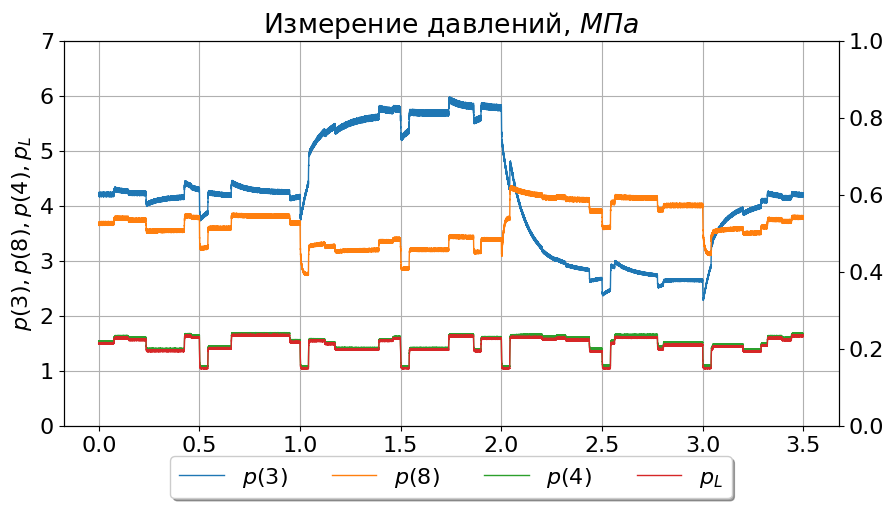

In [142]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df['x'][::denominator], df_ident['p_3'][:], lw=1, label="$p(3)$")
p2, = ax.plot(df['x'][::denominator], df_ident['p_8'][:], lw=1, label="$p(8)$")
p3, = ax.plot(df['x'][::denominator], df_ident['p_4'][:], lw=1, label="$p(4)$")
p4, = ax.plot(df['x'][::denominator], df_ident['p_L'][:], lw=1, label="$p_L$")

ax.set(ylim=(0, 7), xlabel="Сутки", ylabel="$p(3), p(8), p(4),p_L $")
#twin1.set(ylim=(0, 8), ylabel="$p(3)$, $p(8)$")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3, p4])
plt.title('Измерение давлений, $МПа$')
ax.grid()
plt.show()

In [143]:
# Идентификация через производные

from dataclasses import dataclass, field
from typing import List

@dataclass
class CalculatedValues:
  values: List[float] = field(default_factory=list)

  def add(self, element):
    self.values.append(element)


calc_q = CalculatedValues()
calc__q = CalculatedValues()
calc_q_N = CalculatedValues()
calc_dp = CalculatedValues()
calc_dp_3 = CalculatedValues()
calc_dp_4 = CalculatedValues()
calc_y = CalculatedValues()

for _k in range(ident_k-1):
  q_N = (1/(gamma*r_U))*(df_ident['p_8'][_k+1]-p_L)

  dp_3 = (1/ident_dt)*(df_ident['p_3'][_k+1]-df_ident['p_3'][_k])
  dp_4 = (1/ident_dt)*(df_ident['p_4'][_k+1]-df_ident['p_4'][_k])
  dp = dp_3 - dp_4

  q = q_N + ((S_t/gamma) * dp)

  if _k == 0:
    _q = q
  else:
    _q = _q + (ident_dt/T_2)*(q - _q)

  y = df_ident['p_3'][_k] + gamma*(H_R-H_N+r_K*q)

  calc_q_N.add(q_N)
  calc_q.add(q)
  calc__q.add(_q)
  calc_dp.add(dp)
  calc_dp_3.add(dp_3)
  calc_dp_4.add(dp_4)
  calc_y.add(y)

calc_df = pd.DataFrame({'q_N': calc_q_N.values, 'q': calc_q.values, '_q': calc__q.values, 'dp': calc_dp.values, 'dp_3': calc_dp_3.values, 'dp_4': calc_dp_4.values, 'y': calc_y.values})

In [144]:
# формируем и заполняем матрицу размерностью 2x2
A = np.empty((3, 3))
A[[0], [0]] = ident_k-1
A[[0], [1]] = sum(calc_q.values)
A[[0], [2]] = sum(calc__q.values)

A[[1], [0]] = sum(calc_q.values)
A[[1], [1]] = sum([value**2 for value in calc_q.values])
A[[1], [2]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(ident_k-1)])

A[[2], [0]] = sum(calc__q.values)
A[[2], [1]] = sum([calc__q.values[i]*calc_q.values[i] for i in range(ident_k-1)])
A[[2], [2]] = sum([value**2 for value in calc__q.values])
A


array([[ 3.49990000e+04,  2.94276757e+06, -1.85118706e+06],
       [ 2.94276757e+06,  7.83990685e+09, -1.50863268e+08],
       [-1.85118706e+06, -1.50863268e+08,  2.29677731e+09]])

In [145]:
# находим обратную матрицу
A = np.linalg.inv(A)
# формируем и заполняем матрицу размерностью 3x1
C = np.empty((3, 1))
C[0] = sum(calc_y.values)
C[1] = sum([calc_y.values[i]*calc_q.values[i] for i in range(ident_k-1)])
C[2] = sum([calc_y.values[i]*calc__q.values[i] for i in range(ident_k-1)])
C


array([[   441081.60395749],
       [ 67013776.19413723],
       [-23940146.54875644]])

In [146]:
# умножаем матрицу на вектор
ww = np.dot(A, C)
ww

array([[ 1.22561234e+01],
       [ 3.94184440e-03],
       [-2.86092180e-04]])

In [147]:
import scipy
X = np.array([[1 for _ in range(ident_k-1)],
              calc_q.values,
              calc__q.values]).T
y = np.array([calc_y.values]).T
b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
print(b)

[[ 1.22561234e+01]
 [ 3.94184440e-03]
 [-2.86092180e-04]]


In [148]:
A

array([[ 3.07782481e-05, -1.10895000e-08,  2.40786497e-08],
       [-1.10895000e-08,  1.31709544e-10, -2.86752417e-13],
       [ 2.40786497e-08, -2.86752417e-13,  4.54781062e-10]])

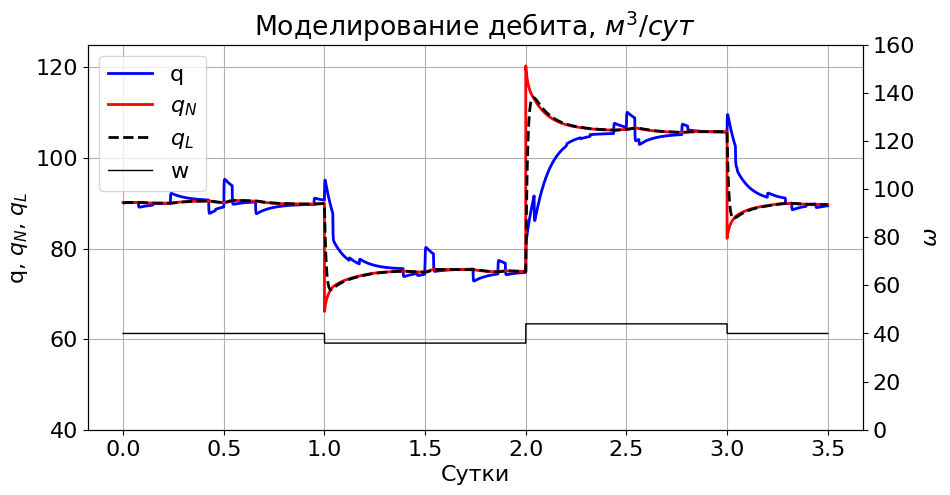

In [149]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
twin1 = ax.twinx()

plt.rcParams.update({'font.size': 16})

p1, = ax.plot(df['x'], df['q'], 'b', lw=2, label="q")
p2, = ax.plot(df['x'], df['q_N'], 'r', lw=2, label="$q_N$")
p3, = ax.plot(df['x'], df['q_L'], 'k--', lw=2, label="$q_L$")

p4, = twin1.plot(df['x'],  df['u']*40,'k', lw=1, label="w")


ax.set(ylim=(40, 125), xlabel="Сутки", ylabel="q, $q_N$, $q_L$")
twin1.set(ylim=(0, 160), ylabel="$\omega$")

plt.title('Моделирование дебита, $м^3/сут$')

ax.legend(handles=[p1, p2, p3, p4])
ax.grid()
plt.show()

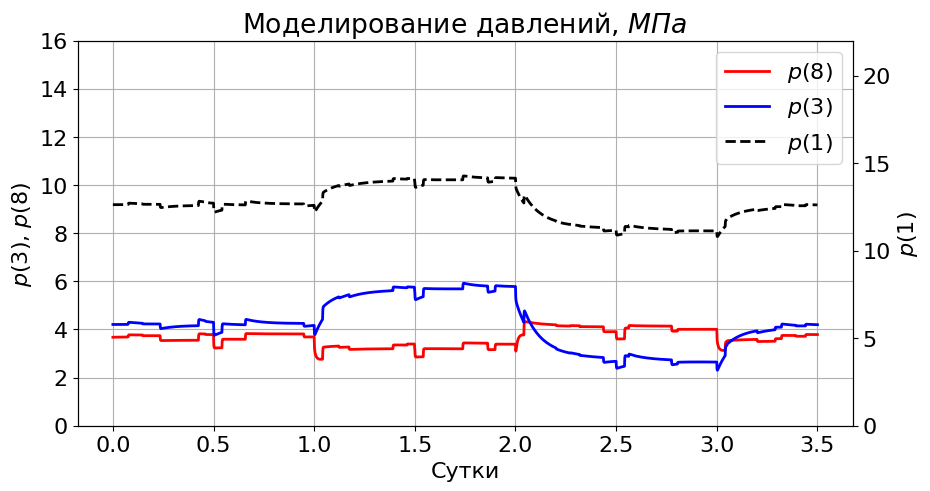

In [150]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df['x'], df['p_8'], 'r', lw=2, label="$p(8)$")
p2, = ax.plot(df['x'], df['p_3'], 'b', lw=2, label="$p(3)$")

p3, = twin1.plot(df['x'], df['p_1'], 'k--', lw=2, label="$p(1)$")


ax.set(ylim=(0, 16), xlabel="Сутки", ylabel="$p(3)$, $p(8)$")
twin1.set(ylim=(0, 22), ylabel="$p(1)$")
plt.title('Моделирование давлений, $МПа$')
ax.legend(handles=[p1, p2, p3])
ax.grid()
plt.show()

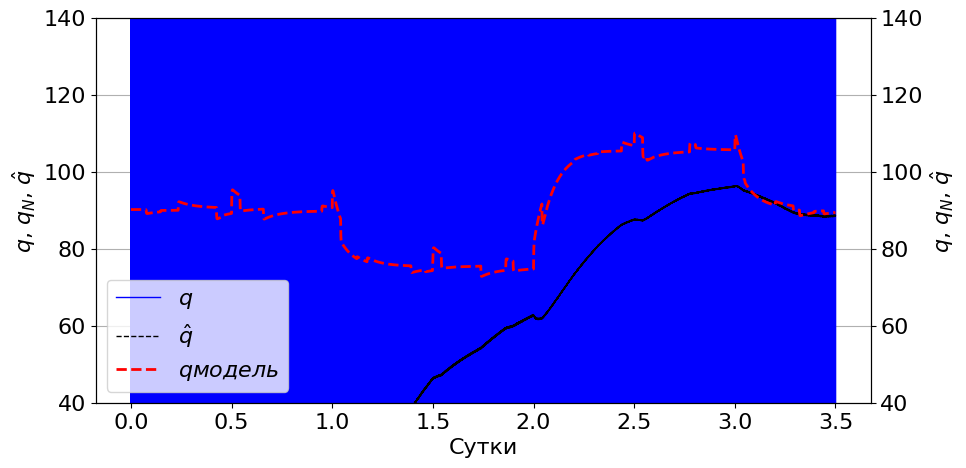

In [151]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(df['x'][:-denominator:denominator], calc_df['q'], 'b', lw=1, label="$q$")
#p2, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['q_N'][:ident_k], 'r', lw=2, label="$q_N$")
p3, = ax.step(df['x'][:-denominator:denominator], calc_df['_q'], 'k--', lw=1, label="$\hat{q}$")


p4, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q модель$")
#p5, = twin1.plot(df['x'], df['q_N'], 'r--', lw=1, label="$q_N модель$")


ax.set(ylim=(40, 140), xlabel="Сутки", ylabel="$q$, $q_N$, $\hat{q}$")
twin1.set(ylim=(40, 140), ylabel="$q$, $q_N$, $\hat{q}$")

ax.legend(handles=[p1, p3, p4])
ax.grid()
plt.show()

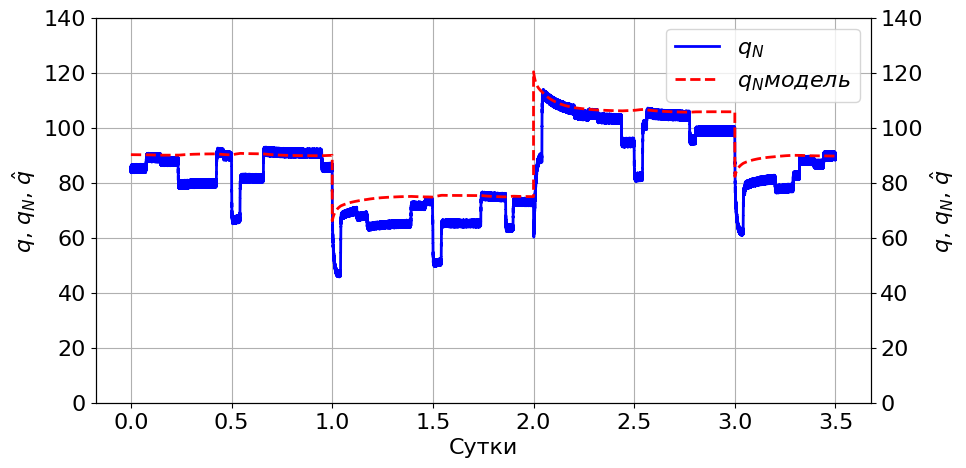

In [152]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

#p1, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['q'][:ident_k], 'b', lw=3, label="$q$")
p2, = ax.step(df['x'][:-denominator:denominator], calc_df['q_N'], 'b', lw=2, label="$q_N$")
#p3, = ax.plot([index*denominator for index in df['x'][:ident_k-1]], calc_df['_q'][:ident_k], 'k--', lw=1, label="$\hat{q}$")


#p4, = twin1.plot(df['x'], df['q'], 'r--', lw=2, label="$q модель$")
p5, = twin1.plot(df['x'], df['q_N'], 'r--', lw=2, label="$q_N модель$")


ax.set(ylim=(0, 140), xlabel="Сутки", ylabel="$q$, $q_N$, $\hat{q}$")
twin1.set(ylim=(0, 140), ylabel="$q$, $q_N$, $\hat{q}$")

ax.legend(handles=[p2, p5])
ax.grid()
plt.show()

In [153]:
# Идентификация через фильтр

from dataclasses import dataclass, field
from typing import List

@dataclass
class CalculatedValues:
  values: List[float] = field(default_factory=list)

  def add(self, element):
    self.values.append(element)


calc_q_L = CalculatedValues()
calc_dp = CalculatedValues()
calc_dp_t = CalculatedValues()
calc_q_t = CalculatedValues()
calc_p_1_t = CalculatedValues()
calc__q_t = CalculatedValues()

for _k in range(ident_k-1):

  q_L = (1/(gamma*df_ident['r_U'][_k]))*(df_ident['p_8'][_k]-df_ident['p_L'][_k])
  dp = (df_ident['p_3'][_k]-df_ident['p_4'][_k])

  if _k == 0:
    dp_t = dp


  q_t = q_L + ((S_t/(gamma*t_N)) * (dp - dp_t))

  if _k == 0:
    _q_t = q_t
    _p_3 = df_ident['p_3'][0]

  p_1_t = _p_3 + gamma*(H_R-H_N+r_K*q_t)

  calc_q_L.add(q_L)
  calc_dp.add(dp)
  calc_dp_t.add(dp_t)
  calc_q_t.add(q_t)
  calc_p_1_t.add(p_1_t)
  calc__q_t.add(_q_t)

  dp_t = dp_t + (ident_dt/t_N)*(dp - dp_t)
  _q_t = _q_t + (ident_dt/T_2)*(q_t - _q_t)
  _p_3 = _p_3 + (ident_dt/t_N)*(df_ident['p_3'][_k] - _p_3)


calc_df = pd.DataFrame({'q_L': calc_q_L.values,
                        'dp': calc_dp.values,
                        'dp_t': calc_dp_t.values,
                        'q_t': calc_q_t.values,
                        'p_1_t': calc_p_1_t.values,
                        '_q_t': calc__q_t.values,
                        })

calc_df.iloc[575:600]

,q_L,dp,dp_t,q_t,p_1_t,_q_t
575,92.782859,2.704654,2.677562,96.144144,12.657123,89.900197
576,88.915731,2.692810,2.677833,90.773931,12.635769,89.901758
577,87.509048,2.622804,2.677983,80.663069,12.595294,89.901976
578,91.783785,2.641631,2.677431,87.342066,12.621795,89.899666
579,92.177155,2.727034,2.677073,98.375796,12.665969,89.899026
580,88.329270,2.657524,2.677573,85.841820,12.615805,89.901146
581,91.279911,2.688125,2.677372,92.614019,12.642935,89.900131
582,89.252582,2.635476,2.677480,84.041176,12.608415,89.900809
583,91.192851,2.634824,2.677060,85.952676,12.615756,89.899344
584,89.788284,2.681693,2.676637,90.415540,12.633426,89.898358


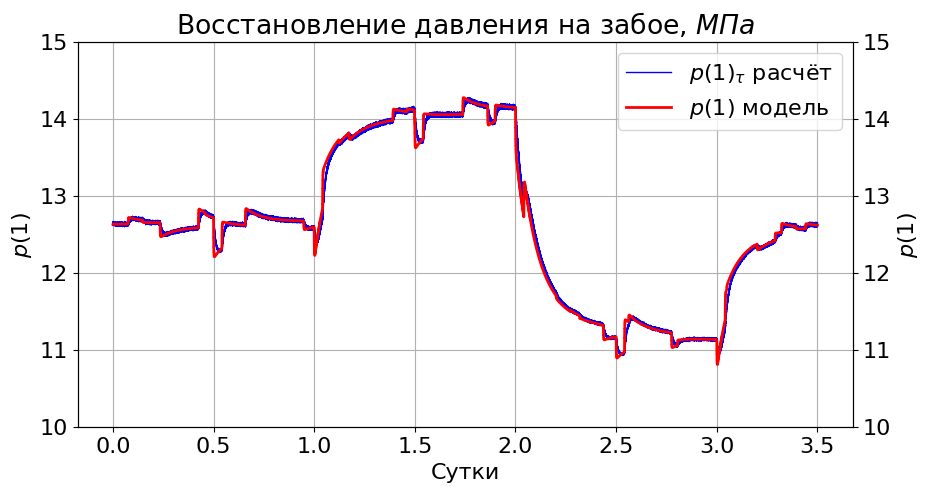

In [154]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p2, = twin1.step(df['x'], df['p_1'], 'r', lw=2, label="$p(1)$ модель")
p1, = ax.step(df['x'][:-denominator:denominator], calc_df['p_1_t'], 'b', lw=1, label=r"$p(1)_\tau$ расчёт")


ax.set(ylim=(10, 15), xlabel="Сутки", ylabel="$p(1)$")
twin1.set(ylim=(10, 15), ylabel="$p(1)$")

plt.title('Восстановление давления на забое, $МПа$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

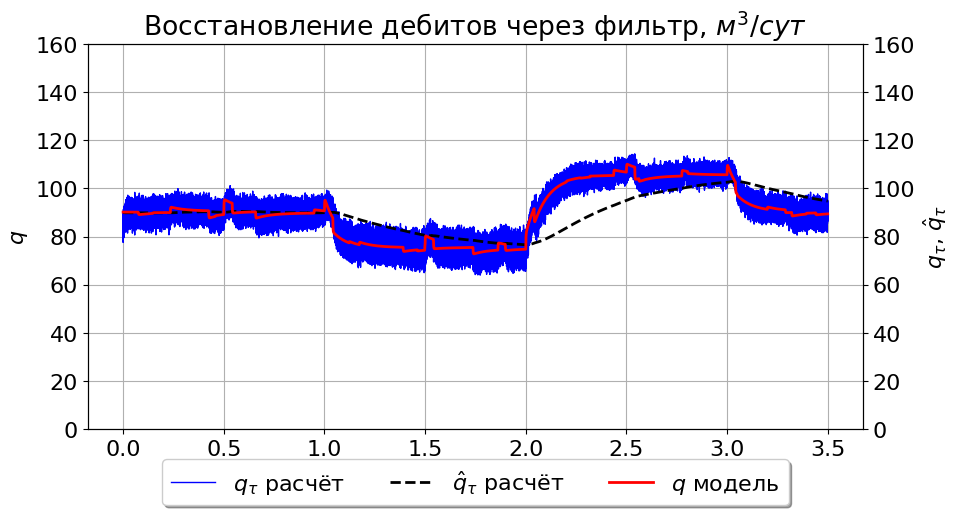

In [155]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.step(df['x'][:-denominator:denominator], calc_df['q_t'], 'b', lw=1, label=r"$q_\tau$ расчёт")
p2, = ax.step(df['x'][:-denominator:denominator], calc_df['_q_t'], 'k--', lw=2, label=r"$\^{q}_\tau$ расчёт")
p3, = twin1.plot(df['x'], df['q'], 'r', lw=2, label="$q$ модель")


ax.set(ylim=(0, 160), xlabel="Сутки", ylabel="$q$")
twin1.set(ylim=(0, 160), ylabel=r"$q_\tau$, $\^{q}_\tau$")

plt.title('Восстановление дебитов через фильтр, $м^3/сут$')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5, handles=[p1, p2, p3])
ax.grid()
plt.show()

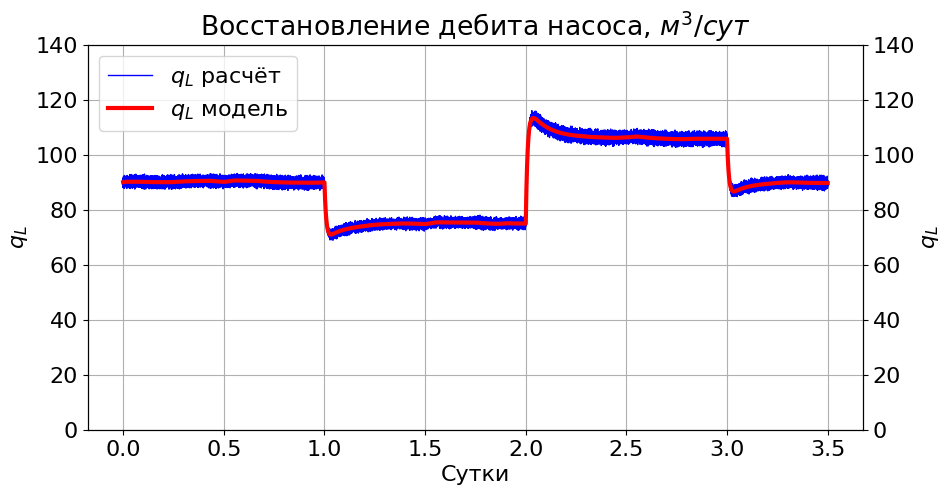

In [156]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

twin1 = ax.twinx()

p1, = ax.plot(df['x'][:-denominator:denominator], calc_df['q_L'], 'b', lw=1, label=r"$q_L$ расчёт")
p2, = ax.plot(df['x'], df['q_L'], 'r', lw=3, label="$q_L$ модель")

ax.set(ylim=(0, 140), xlabel="Сутки", ylabel="$q_L$")
twin1.set(ylim=(0, 140), ylabel=r"$q_L$")

plt.title('Восстановление дебита насоса, $м^3/сут$')

ax.legend(handles=[p1, p2])
ax.grid()
plt.show()

In [157]:
import scipy
X = np.array([[1 for _ in range(ident_k-1)],
              calc_q_t.values,
              calc__q_t.values]).T
y = np.array([calc_p_1_t.values]).T
b, squared_error_sum, matrix_rank, SVD_ = scipy.linalg.lstsq(X, y)
print(b)

[[21.65834897]
 [-0.06784705]
 [-0.03234326]]


In [158]:
p_error = (p_R - b[0][0])/p_R
p_error *= 100
p_error

np.float64(-0.0385633684537023)

In [159]:
r_1_error = (r_1 - b[1][0])/r_1
r_1_error *= 100
r_1_error

np.float64(181.74343716847937)

In [160]:
r_2_error = (r_2 - b[2][0])/r_2
r_2_error *= 100
r_2_error

np.float64(290.25445347180175)

In [161]:
# формируем и заполняем матрицу размерностью 2x2
A = np.empty((3, 3))
A[[0], [0]] = ident_k-1
A[[0], [1]] = sum(calc_q_t.values)
A[[0], [2]] = sum(calc__q_t.values)

A[[1], [0]] = sum(calc_q_t.values)
A[[1], [1]] = sum([value**2 for value in calc_q_t.values])
A[[1], [2]] = sum([calc__q_t.values[i]*calc_q_t.values[i] for i in range(ident_k-1)])

A[[2], [0]] = sum(calc__q_t.values)
A[[2], [1]] = sum([calc__q_t.values[i]*calc_q_t.values[i] for i in range(ident_k-1)])
A[[2], [2]] = sum([value**2 for value in calc__q_t.values])

# находим обратную матрицу
A = np.linalg.inv(A)
# формируем и заполняем матрицу размерностью 3x1
C = np.empty((3, 1))
C[0] = sum(calc_p_1_t.values)
C[1] = sum([calc_p_1_t.values[i]*calc_q_t.values[i] for i in range(ident_k-1)])
C[2] = sum([calc_p_1_t.values[i]*calc__q_t.values[i] for i in range(ident_k-1)])

# умножаем матрицу на вектор
ww = np.dot(A, C)
ww

array([[21.65834897],
       [-0.06784705],
       [-0.03234326]])